# Second-Order Euler Solver



We now have all the pieces needed to solve the Euler equation.  The main difference with the Burgers's are:

* We are updating 3 variables, $\rho, \rho u, \rho E$
* The Riemann problem is more complex
* Our timestep constraint needs to consider the fastest wave

Our code will have essentially the same structure we used for advection and the Burgers' solver:

  * Create our numerical grid
  
  * Set the initial conditions
  
  * Main timestep evolution loop
  
    * Compute the timestep
    
    * Loop to advance one step (count depends on the number of stages in the integrator)
  
        * Reconstruct the state to interfaces
    
        * Solve Riemann problem to find the fluxes through the interface
    
        * Do a conservative update of the state to the stage
    
    * Output

## Grid and variables

We'll use the same finite-volume grid class we used with the earlier solvers.

The main information we need to setup the grid are the number of zones in the interior and the number of ghost cells.

To make life easier, we'll have a simple class with indices that we use to index the fluid state arrays.  We can pass this around and be sure that we are always accessing the correct fluid state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to
    refer to the different fluid components"""
    def __init__(self, gamma=1.4, C=0.8):
        self.nvar = 3
    
        # conserved variables
        self.urho = 0
        self.umx = 1
        self.uener = 2
    
        # primitive variables
        self.qrho = 0
        self.qu = 1
        self.qp = 2
    
        # EOS gamma
        self.gamma = gamma
        
        # CFL number
        self.C = C

Next we update our ``FVGrid`` class.  The main difference from advection
is that we now consider the state array to be 2-dimensional, with the second dimension the component.

In [3]:
class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0, vars=None):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.lo = ng
        self.hi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        
        self.v = vars

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        return np.squeeze(np.zeros((self.nx+2*self.ng, nc), dtype=np.float64))

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """
        if atmp.ndim == 2:
            for n in range(atmp.shape[-1]):
                atmp[0:self.lo, n] = atmp[self.lo, n]
                atmp[self.hi+1:, n] = atmp[self.hi, n]            
        else:
            atmp[0:self.lo] = atmp[self.lo]
            atmp[self.hi+1:] = atmp[self.hi]

## Reconstruction

We need to use the cell-averages to figure out what the fluid state is on the interfaces.  We'll _reconstruct_ the cell-averages as piecewise lines that give us the same average in the zone.  We then follow these lines to the interfaces to define the left and right state at each interface.

Usually we work in terms of the primitive variables, ${\bf q} = (\rho, u, p)$.  So we first write a routine to do the algebraic transformation from conservative to primitive variables:
\begin{align*}
\rho &= \rho \\
u &= \frac{(\rho u)}{\rho} \\
p &= \left ( (\rho E) - \frac{1}{2} \frac{(\rho u)^2}{\rho}\right )(\gamma - 1)
\end{align*}

In [4]:
def cons_to_prim(g, U):
    """take a conservative state U and return the corresponding primitive
    variable state as a new array."""
    q = g.scratch_array(nc=g.v.nvar)

    q[:, g.v.qrho] = U[:, g.v.urho]
    q[:, g.v.qu] = U[:, g.v.umx]/U[:, g.v.urho]
    rhoe = U[:, g.v.uener] - 0.5*q[:, g.v.qrho]*q[:, g.v.qu]**2
    q[:, g.v.qp] = rhoe*(g.v.gamma - 1.0)

    return q

Next we need a routine to create the interface states.  We'll do this the samer way as we did with Burgers': construct a slope for each zone, $\Delta {\bf q}$ based on the average state in the neighboring zones and use that to find the left and right states at each interace.

We'll continue to use the minmod limiter.

In [5]:
def states(g, U):

    q = cons_to_prim(g, U)

    # construct the slopes
    dq = g.scratch_array(nc=g.v.nvar)

    for n in range(g.v.nvar):        
        dl = g.scratch_array()
        dr = g.scratch_array()

        dl[g.lo-1:g.hi+2] = q[g.lo:g.hi+3,n] - q[g.lo-1:g.hi+2,n]
        dr[g.lo-1:g.hi+2] = q[g.lo-1:g.hi+2,n] - q[g.lo-2:g.hi+1,n]

        # these where's do a minmod()
        d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
        dq[:, n] = np.where(dl*dr > 0.0, d1, 0.0)

    # now make the states
    q_l = g.scratch_array(nc=g.v.nvar)
    q_l[g.lo:g.hi+2, :] = q[g.lo-1:g.hi+1, :] + 0.5*dq[g.lo-1:g.hi+1, :]

    q_r = g.scratch_array(nc=g.v.nvar)
    q_r[g.lo:g.hi+2, :] = q[g.lo:g.hi+2, :] - 0.5*dq[g.lo:g.hi+2, :]
    
    return q_l, q_r

## Riemann problem and conservative update

After doing our reconstruction, we are left with a left and right state on an interface.  To find the unique fluid state on the interface, we solve a _Riemann problem,

$${\bf q}_{i+1/2} = \mathcal{R}({\bf q}_{i+1/2,L}, {\bf q}_{i+1/2,R})$$

We'll use the solver we developed in the previous notebooks.

One we have the interface state, we can compute the fluxes using this state:

In [6]:
def cons_flux(state, v):
    """ given an interface state, return the conservative flux"""
    flux = np.zeros((v.nvar), dtype=np.float64)

    flux[v.urho] = state.rho * state.u
    flux[v.umx] = flux[v.urho] * state.u + state.p
    flux[v.uener] = (0.5 * state.rho * state.u**2 +
                     state.p/(v.gamma - 1.0) + state.p) * state.u
    return flux

To keep things simple, the Riemann solver is in a module now that we import.

In [7]:
import riemann_exact as re

For a method-of-lines approach, we want to just compute the righthand side, $A = -\partial F/\partial x$.  Then we will turn our PDE into an ODE for time:

$$\frac{\partial \langle U\rangle_i}{\partial t} = -A_i = - \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x}$$

This routine will take the conserved state, $U$, construct the left and right states at all interfaces, solve the Riemann problem to get the unique state on the boundary, and then compute the advective term and return it.

In [8]:
def make_flux_divergence(g, U):
        
    # get the states
    q_l, q_r = states(g, U)

    # now solve the Riemann problem
    flux = g.scratch_array(nc=g.v.nvar)
    
    for i in range(g.lo, g.hi+2):
        sl = re.State(rho=q_l[i, g.v.qrho], u=q_l[i, g.v.qu], p=q_l[i, g.v.qp])
        sr = re.State(rho=q_r[i, g.v.qrho], u=q_r[i, g.v.qu], p=q_r[i, g.v.qp])
        rp = re.RiemannProblem(sl, sr, gamma=g.v.gamma)
        rp.find_star_state()
        q_int = rp.sample_solution()
        flux[i, :] = cons_flux(q_int, g.v)

    A = g.scratch_array(nc=g.v.nvar)
    for n in range(g.v.nvar):
        A[g.lo:g.hi+1, n] = (flux[g.lo:g.hi+1, n] -
                             flux[g.lo+1:g.hi+2, n]) / g.dx

    return A

## Timestep

For the hydro equations, the speeds at which information travels are $u$ and $u \pm c$, so we use the largest speed here to compute the timestep:

$$\Delta t = C \min_i \left \{ \frac{\Delta x}{|u_i| + c_i} \right \}$$

In [9]:
def timestep(g, U):
    
    # compute the sound speed
    q = cons_to_prim(g, U)
    c = g.scratch_array()
    c[g.lo:g.hi+1] = np.sqrt(g.v.gamma *
                             q[g.lo:g.hi+1, g.v.qp] /
                             q[g.lo:g.hi+1, g.v.qrho])

    dt = g.v.C * g.dx / (np.abs(q[g.lo:g.hi+1, g.v.qu]) +
                         c[g.lo:g.hi+1]).max()
    return dt

## Main driver

This is the main driver.

This does 2nd-order RK (or Euler's method) for the integration, and requires that we compute the advection terms twice to advance the solution by $\Delta t$.  The update looks like:
\begin{align*}
U^\star &= U^n + \frac{\Delta t}{2} A(U^n) \\
U^{n+1} &= U^n + \Delta t A(U^\star)
\end{align*}

In [10]:
def mol_solve(nx, C=0.8, tmax=1.0, init_cond=None):
    """Perform 2nd order MOL integration of the Euler equations.
    You need to pass in a function foo(grid) that returns the 
    initial conserved fluid state."""

    v = FluidVars(C=C)
    
    grid = FVGrid(nx, 2, vars=v)
    
    U = init_cond(grid)
    
    t = 0.0
    
    while t < tmax:
        dt = timestep(grid, U)
        if t + dt > tmax:
            dt = tmax - t

        grid.fill_BCs(U)
        k1 = make_flux_divergence(grid, U)

        U_tmp = grid.scratch_array(nc=v.nvar)
        for n in range(v.nvar):
            U_tmp[:, n] = U[:, n] + 0.5 * dt * k1[:, n]

        grid.fill_BCs(U_tmp)
        k2 = make_flux_divergence(grid, U_tmp)

        for n in range(v.nvar):
            U[:, n] += dt * k2[:, n]

        t += dt

    return grid, U

## Example: Sod's problem

The Sod problem is a standard test problem, consisting of a left and right state separated by an initial discontinuity.  As time evolves, a rightward moving shock and contact and leftward moving rarefaction form.  We've actually been looking at these initial conditions as we developed the Riemann solver.

One reason this problem is so popular is that you can find the exact solution (it's just the Riemann problem) and compare the performance of your code to the exact solution.

In [11]:
def sod(g):
    
    U = g.scratch_array(nc=g.v.nvar)
    
    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1.0
    rho_r = 0.125
    u_r = 0.0
    p_r = 0.1

    idx_l = g.x < 0.5
    idx_r = g.x >= 0.5

    U[idx_l, g.v.urho] = rho_l
    U[idx_l, g.v.umx] =  rho_l * u_l
    U[idx_l, g.v.uener] = p_l/(g.v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, g.v.urho] = rho_r
    U[idx_r, g.v.umx] =  rho_r * u_r
    U[idx_r, g.v.uener] = p_r/(g.v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U

In [16]:
g, U = mol_solve(128, tmax=0.2, init_cond=sod)

Let's read in the exact solution from a data file

In [17]:
sod_exact = np.genfromtxt("sod-exact.out", skip_header=2, names=True)

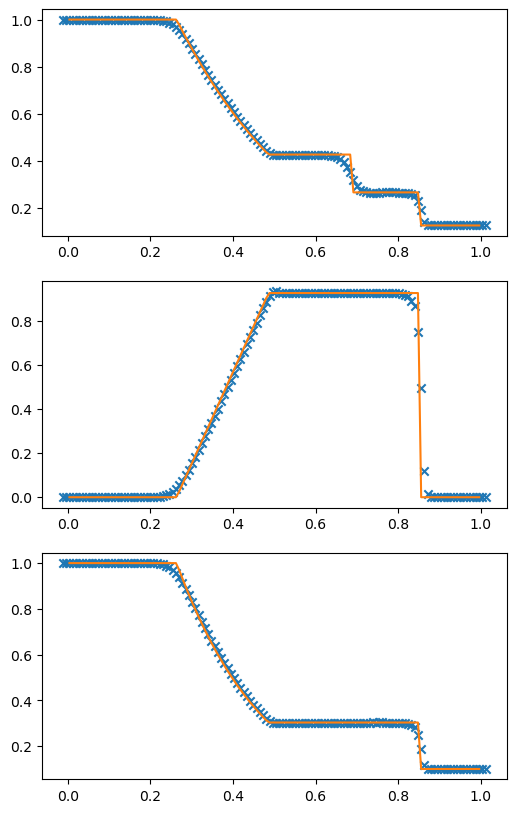

In [18]:
v = FluidVars()

q = cons_to_prim(g, U)
fig = plt.figure()

ax = fig.add_subplot(311)
ax.scatter(g.x, q[:,v.qrho], marker="x", color="C0")
ax.plot(sod_exact["x"], sod_exact["rho"], color="C1")

ax = fig.add_subplot(312)
ax.scatter(g.x, q[:,v.qu], marker="x", color="C0")
ax.plot(sod_exact["x"], sod_exact["u"], color="C1")

ax = fig.add_subplot(313)
ax.scatter(g.x, q[:,v.qp], marker="x", color="C0")
ax.plot(sod_exact["x"], sod_exact["p"], color="C1")

fig.set_size_inches((6, 10))

In [19]:
def double_rarefaction(g):

    U = g.scratch_array(nc=g.v.nvar)
    
    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = -2.0
    p_l = 0.4
    rho_r = 1.0
    u_r = 2.0
    p_r = 0.4

    idx_l = g.x < 0.5
    idx_r = g.x >= 0.5

    U[idx_l, g.v.urho] = rho_l
    U[idx_l, g.v.umx] =  rho_l * u_l
    U[idx_l, g.v.uener] = p_l/(g.v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, g.v.urho] = rho_r
    U[idx_r, g.v.umx] =  rho_r * u_r
    U[idx_r, g.v.uener] = p_r/(g.v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U   

In [20]:
g, U = mol_solve(128, tmax=0.1, C=0.2, init_cond=double_rarefaction)

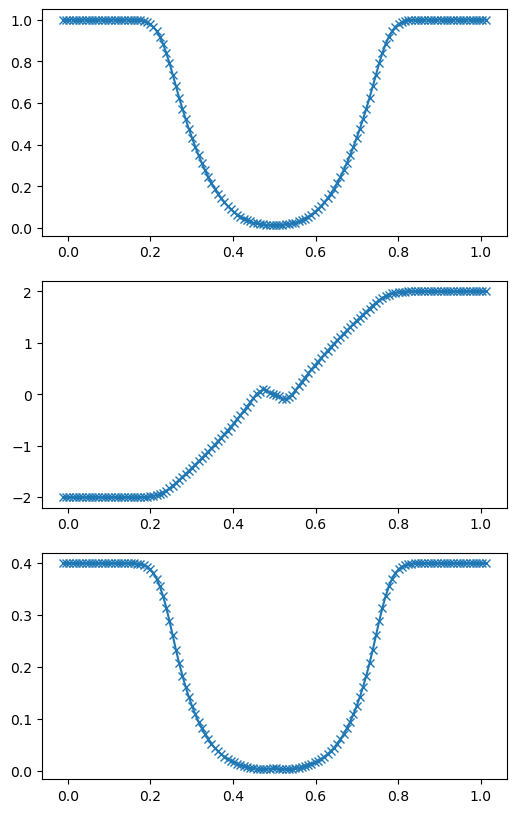

In [21]:
v = FluidVars()

q = cons_to_prim(g, U)
fig = plt.figure()

ax = fig.add_subplot(311)
ax.plot(g.x, q[:,v.qrho], marker="x", color="C0")

ax = fig.add_subplot(312)
ax.plot(g.x, q[:,v.qu], marker="x", color="C0")

ax = fig.add_subplot(313)
ax.plot(g.x, q[:,v.qp], marker="x", color="C0")

fig.set_size_inches((6, 10))